# Linear Regression for Salary Data

1. Dataset Information
2. Data Preprocessing
3. Train Models

| | Model |
|:--| :--|
| A | Job Title feature modified using One Hot Encoding |
| B | Job Title feature modified using Label Encoding |
| C | Job Title feature dropped from dataset |

4. Comparison of Models
5. Feature Selection
6. MLP Implementation

In [9]:
%pip install sktime

In [10]:
## imports
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sktime.performance_metrics.forecasting import mean_squared_percentage_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


## 1. Dataset Information

In [11]:
data = pd.read_csv('Salary Data.csv')
print(data.head(5))
print(data.info())

    Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  373 non-null    float64
 1   Gender               373 non-null    object 
 2   Education Level      373 non-null    object 
 3   Job Title            373 non-null    object 
 4   Years of Experience  373 non-null    float64
 5   Salary

In [12]:
salary_dist = px.histogram(data, x="Salary")
salary_dist.show()

In [13]:
gender_count = data['Gender'].value_counts().reset_index()
gender_dist = px.pie(gender_count, values='count', names="Gender", title="Count by Gender")
gender_dist.show()

In [14]:
edu_count = data['Education Level'].value_counts().reset_index()
edu_dist = px.pie(edu_count, values='count', names="Education Level", title="Education Level by Highest Degree")
edu_dist.show()

## 2. Data Preprocessing

https://scikit-learn.org/stable/modules/preprocessing.html
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder

In [15]:
####################
#  Clean data
####################
# Remove na
clean_df = data.dropna()
# Remove duplicates
clean_df = clean_df.drop_duplicates()
# Check for negative salary
negative_salaries = clean_df[clean_df['Salary'] < 0]
if (negative_salaries.shape[0] > 0):
    print("Warning: There are salaries < 0!!")

####################
#  Converting the Categorial data into numbers
####################
label_encoder = LabelEncoder()
# Education Level
clean_df['Education Level'] = label_encoder.fit_transform(clean_df['Education Level'])
# One Hot Encode Gender & Job Title
job_1hot_df = pd.get_dummies(clean_df)

job_encoder = LabelEncoder()
job_label_df  = clean_df
job_label_df['Job Title'] = label_encoder.fit_transform(clean_df['Job Title'])
job_label_df = pd.get_dummies(job_label_df)

no_job_df = clean_df.drop(['Job Title'], axis=1)
no_job_df = pd.get_dummies(no_job_df)

print("One Hot")
print(job_1hot_df.head(5))
print("Label Encoding")
print(job_label_df.head(5))
print("No Job")
print(no_job_df.head(5))

One Hot
    Age  Education Level  Years of Experience    Salary  Gender_Female  \
0  32.0                0                  5.0   90000.0          False   
1  28.0                1                  3.0   65000.0           True   
2  45.0                2                 15.0  150000.0          False   
3  36.0                0                  7.0   60000.0           True   
4  52.0                1                 20.0  200000.0          False   

   Gender_Male  Job Title_Account Manager  Job Title_Accountant  \
0         True                      False                 False   
1        False                      False                 False   
2         True                      False                 False   
3        False                      False                 False   
4         True                      False                 False   

   Job Title_Administrative Assistant  Job Title_Business Analyst  ...  \
0                               False                       False  ...

In [16]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 324 entries, 0 to 371
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  324 non-null    float64
 1   Gender               324 non-null    object 
 2   Education Level      324 non-null    int64  
 3   Job Title            324 non-null    int64  
 4   Years of Experience  324 non-null    float64
 5   Salary               324 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 17.7+ KB


## 3. Train Models

In [17]:
all_metrics = []

def update_metrics(label, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    acc = 1 - mean_squared_percentage_error(y_true, y_pred)

    print(f'Accuracy: {acc}')
    print(f'MSE     : {mse}')
    return [label, mse, rmse, r2, acc]

def show_coeff(model, features):
    coeff = model.coef_
    intercept = model.intercept_

    coeff_df = pd.DataFrame({
        'Feature': features.columns.tolist(),
        'Coefficients': coeff,
        '|Coefficients|': [abs(i) for i in coeff]
    })

    print(coeff_df.sort_values(by='|Coefficients|', ascending=False).head(10))

#### Model A - Job Title using One Hot Encoder

In [18]:
x = job_1hot_df.drop(['Salary'], axis=1)
y = job_1hot_df['Salary']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= .2, random_state=42)
# x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, train_size=.5, random_state=42)

# print(f'X Train: {len(x_train)}, Y Train: {len(y_train)}')
# print(f'X Test: {len(x_test)}, Y Test: {len(y_test)}')
# print(f'X Valid: {len(y_valid)}, Y Valid: {len(y_valid)}')

## Create model to estimate salary based all columns
model = LinearRegression()
model.fit(x_train,y_train)

y_pred = model.predict(x_test)
all_metrics.append(update_metrics("1-Hot Job", y_test, y_pred))

# line equation
show_coeff(model, x)

Accuracy: -1.5138809480627702e+19
MSE     : 6.3515385534851494e+28
                                Feature  Coefficients  |Coefficients|
3                         Gender_Female  9.828199e+15    9.828199e+15
4                           Gender_Male  9.828199e+15    9.828199e+15
5             Job Title_Account Manager -1.564827e+15    1.564827e+15
20   Job Title_Customer Success Manager  5.889024e+14    5.889024e+14
15                 Job Title_Copywriter -3.312470e+14    3.312470e+14
11                        Job Title_CEO  1.837587e+14    1.837587e+14
13   Job Title_Chief Technology Officer  1.837587e+14    1.837587e+14
12         Job Title_Chief Data Officer  1.837587e+14    1.837587e+14
176             Job Title_VP of Finance  1.837587e+14    1.837587e+14
104         Job Title_Research Director  1.837587e+14    1.837587e+14


#### Model B -  Job Title using Label Encoding

In [19]:
x = job_label_df.drop(['Salary'], axis=1)
y = job_label_df['Salary']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= .2, random_state=42)
# x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, train_size=.5, random_state=42)

## Create model to estimate salary based all columns
model = LinearRegression()

model.fit(x_train,y_train)

y_pred = model.predict(x_test)
all_metrics.append(update_metrics("Label Encoder Job", y_test, y_pred))

# line equation
show_coeff(model, x)

Accuracy: 0.9734367364534153
MSE     : 205754135.71726152
               Feature  Coefficients  |Coefficients|
1      Education Level  15422.735860    15422.735860
5          Gender_Male   3694.539168     3694.539168
4        Gender_Female  -3694.539168     3694.539168
3  Years of Experience   2892.128506     2892.128506
0                  Age   2812.906962     2812.906962
2            Job Title     19.576956       19.576956


#### Mobel C - Job Title Removed

In [20]:
x = no_job_df.drop(['Salary'], axis=1)
y = no_job_df['Salary']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= .2, random_state=42)
# x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, train_size=.5, random_state=42)

## Create model to estimate salary based all columns
model = LinearRegression()

model.fit(x_train,y_train)

y_pred = model.predict(x_test)
all_metrics.append(update_metrics("Drop Job Title", y_test, y_pred))

# line equation
show_coeff(model, x)

Accuracy: 0.9733547523748971
MSE     : 205342321.19904485
               Feature  Coefficients  |Coefficients|
1      Education Level  15488.204557    15488.204557
4          Gender_Male   3750.154843     3750.154843
3        Gender_Female  -3750.154843     3750.154843
0                  Age   2886.497521     2886.497521
2  Years of Experience   2822.257560     2822.257560


## 4. Comparison of Models

In [21]:
def print_models_summ(df):
    compare_df = pd.DataFrame({
        'Model': [sublist[0] for sublist in df],
        'MSE': [sublist[1] for sublist in df],
        'RMSE': [sublist[2] for sublist in df],
        'R2': [sublist[3] for sublist in df],
        'Accuracy': [sublist[4] for sublist in df]
    })

    print(compare_df)

print_models_summ(all_metrics)

               Model           MSE          RMSE            R2      Accuracy
0          1-Hot Job  6.351539e+28  2.520226e+14 -3.360981e+19 -1.513881e+19
1  Label Encoder Job  2.057541e+08  1.434413e+04  8.911231e-01  9.734367e-01
2     Drop Job Title  2.053423e+08  1.432977e+04  8.913410e-01  9.733548e-01


## 5. Feature Selection

In [22]:
features = job_label_df.drop(['Salary'], axis=1)
corr_matrix = features.corr()
heat_map = px.imshow(corr_matrix,
                     labels=dict(color="Correlation"),
                     x=corr_matrix.columns,
                     y=corr_matrix.columns)
heat_map.show()

From the heat map, the following variables have a high correlation and can be removed:

- Gender_Female & Gender_Male -> Remove Gender_Male
- Years of Experience & Age -> Remove Age

In [23]:
x = features.drop(['Gender_Male', 'Age'], axis=1)
y = job_label_df['Salary']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= .2, random_state=42)
# x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, train_size=.5, random_state=42)

## Create model to estimate salary based all columns
model = LinearRegression()
model.fit(x_train,y_train)

y_pred = model.predict(x_test)
all_metrics.append(update_metrics("Drop Gender & Age", y_test, y_pred))

Accuracy: 0.9677115004389796
MSE     : 227471572.44263577


In [24]:
print_models_summ(all_metrics)

               Model           MSE          RMSE            R2      Accuracy
0          1-Hot Job  6.351539e+28  2.520226e+14 -3.360981e+19 -1.513881e+19
1  Label Encoder Job  2.057541e+08  1.434413e+04  8.911231e-01  9.734367e-01
2     Drop Job Title  2.053423e+08  1.432977e+04  8.913410e-01  9.733548e-01
3  Drop Gender & Age  2.274716e+08  1.508216e+04  8.796311e-01  9.677115e-01


## MLP Implementation

In [25]:
## focus on best model -> just drop job title
x = no_job_df.drop(['Salary'], axis=1)
y = no_job_df['Salary']

# change to float32
x = x.astype('float32')
y = y.astype('float32')

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= .1, random_state=42)

x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 324 entries, 0 to 371
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  324 non-null    float32
 1   Education Level      324 non-null    float32
 2   Years of Experience  324 non-null    float32
 3   Gender_Female        324 non-null    float32
 4   Gender_Male          324 non-null    float32
dtypes: float32(5)
memory usage: 8.9 KB


In [26]:
import tensorflow as tf

mlp = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(5,)),
    tf.keras.layers.Normalization(),  #best result on val:   236299520.0000
    tf.keras.layers.Dense(128, activation = 'relu'), #no norm: 258419952
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'linear')
])

mlp.compile(optimizer = 'adam', loss='mse')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

trained_model = mlp.fit(x_train, y_train, epochs=500, batch_size = 8, validation_split=0.1, callbacks = early_stopping)


Epoch 1/500
33/33 [==============================] - 12s 20ms/step - loss: 11934990336.0000 - val_loss: 14715187200.0000
Epoch 2/500
33/33 [==============================] - 0s 12ms/step - loss: 9458472960.0000 - val_loss: 5230042624.0000
Epoch 3/500
33/33 [==============================] - 0s 11ms/step - loss: 1339897216.0000 - val_loss: 675478080.0000
Epoch 4/500
33/33 [==============================] - 0s 9ms/step - loss: 719361344.0000 - val_loss: 617509696.0000
Epoch 5/500
33/33 [==============================] - 0s 12ms/step - loss: 667596160.0000 - val_loss: 568406144.0000
Epoch 6/500
33/33 [==============================] - 0s 9ms/step - loss: 628839232.0000 - val_loss: 542542976.0000
Epoch 7/500
33/33 [==============================] - 0s 11ms/step - loss: 597886272.0000 - val_loss: 539793408.0000
Epoch 8/500
33/33 [==============================] - 0s 12ms/step - loss: 550283648.0000 - val_loss: 466265952.0000
Epoch 9/500
33/33 [==============================] - 0s 15ms/step 

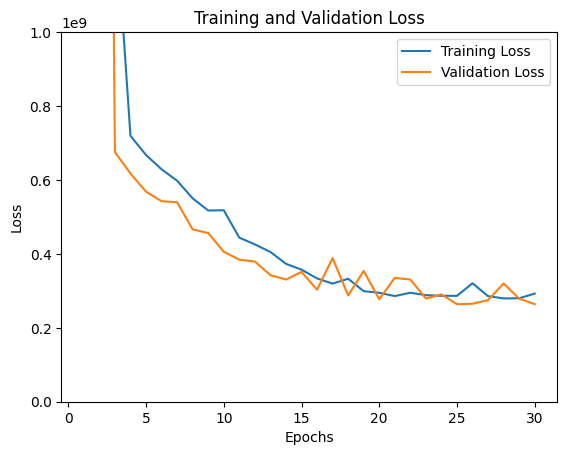

In [27]:
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label= 'Validation Loss')
plt.ylim([0, 1e9])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
y_true = y_test
y_pred = mlp.predict(x_test)

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
acc = 1 - mean_squared_percentage_error(y_true, y_pred)

print(f'Testing set root mean squared error: {rmse}\n')
print(f'Testing set mean squared error: {mse}\n')
print(f'Testing set accuracy: {acc}\n')
print(f'Testing set R squared score: {r2}')

2/2 [==============================] - 0s 8ms/step
Testing set root mean squared error: 15894.15234375

Testing set mean squared error: 252624080.0

Testing set accuracy: 0.9648093618452549

Testing set R squared score: 0.8884012666027076
